# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [15]:
import os.path
from os import path

data_dir = 'processed_celeba_small/'
zip_file = 'processed-celeba-small.zip'

isFile = os.path.isfile(data_dir) 

if path.exists(zip_file) and not path.isdir(data_dir):
    !unzip processed_celeba_small.zip
else:
    print("Make sure you have downloaded https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip")

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [16]:
# data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [20]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [21]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """

    transform = transforms.Compose([transforms.Resize(image_size), # resize to 128x128
                                    transforms.ToTensor()])

    image_data = datasets.ImageFolder(data_dir, transform)
    
    train_dataset = DataLoader(dataset=image_data, batch_size=batch_size, shuffle=True)
    
    # TODO: Implement function and return a dataloader
    
    return train_dataset


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [22]:
# Define function hyperparameters
batch_size = 16
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

<ipython-input-25-d179aabbfe4b>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


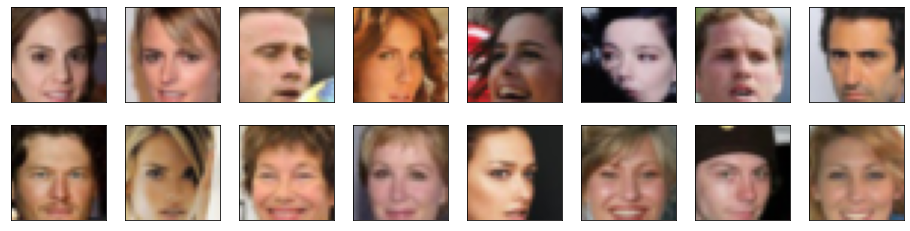

In [25]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [31]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min = feature_range[0]
    max = feature_range[1]
    x = x *(max - min) + min
    
    return x


In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Before Scaled Min: ', img.min())
print('Before Scaled Max: ', img.max())
print()
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Before Scaled Min:  tensor(0.0118)
Before Scaled Max:  tensor(0.9216)

Min:  tensor(-0.9765)
Max:  tensor(0.8431)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [45]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [40]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [41]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [42]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [46]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [62]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        y =  0.02
        m.weight.data.normal_(0, y)
        

    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(0)


## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [60]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [63]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [64]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [65]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)

    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [66]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [67]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
                    
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.5798 | g_loss: 1.4088
Epoch [    1/  100] | d_loss: 0.1980 | g_loss: 3.4898
Epoch [    1/  100] | d_loss: 0.4368 | g_loss: 3.5832
Epoch [    1/  100] | d_loss: 0.1010 | g_loss: 3.6883
Epoch [    1/  100] | d_loss: 0.3413 | g_loss: 1.5740
Epoch [    1/  100] | d_loss: 0.6414 | g_loss: 4.1797
Epoch [    1/  100] | d_loss: 1.3237 | g_loss: 2.0715
Epoch [    1/  100] | d_loss: 0.6070 | g_loss: 2.1214
Epoch [    1/  100] | d_loss: 0.2181 | g_loss: 2.9981
Epoch [    1/  100] | d_loss: 0.5207 | g_loss: 2.3302
Epoch [    1/  100] | d_loss: 0.8189 | g_loss: 2.0684
Epoch [    1/  100] | d_loss: 0.8698 | g_loss: 3.4930
Epoch [    1/  100] | d_loss: 0.8151 | g_loss: 1.8439
Epoch [    1/  100] | d_loss: 0.8010 | g_loss: 2.5462
Epoch [    1/  100] | d_loss: 0.6223 | g_loss: 2.0182
Epoch [    1/  100] | d_loss: 0.5298 | g_loss: 1.6775
Epoch [    1/  100] | d_loss: 1.1873 | g_loss: 2.2535
Epoch [    1/  100] | d_loss: 1.1943 | g_loss: 3.2574
Epoch [    1/  100] | d_loss

Epoch [    2/  100] | d_loss: 1.0374 | g_loss: 2.7143
Epoch [    2/  100] | d_loss: 0.9101 | g_loss: 0.9739
Epoch [    2/  100] | d_loss: 0.7756 | g_loss: 2.3397
Epoch [    2/  100] | d_loss: 1.4107 | g_loss: 0.7265
Epoch [    2/  100] | d_loss: 0.8755 | g_loss: 1.7493
Epoch [    2/  100] | d_loss: 0.9111 | g_loss: 1.1164
Epoch [    2/  100] | d_loss: 1.0986 | g_loss: 1.7601
Epoch [    2/  100] | d_loss: 1.0363 | g_loss: 1.7323
Epoch [    2/  100] | d_loss: 0.4103 | g_loss: 2.6870
Epoch [    2/  100] | d_loss: 0.8288 | g_loss: 1.3008
Epoch [    2/  100] | d_loss: 0.9724 | g_loss: 1.6134
Epoch [    2/  100] | d_loss: 0.9707 | g_loss: 1.5095
Epoch [    2/  100] | d_loss: 0.8371 | g_loss: 1.4839
Epoch [    2/  100] | d_loss: 0.7464 | g_loss: 1.4693
Epoch [    2/  100] | d_loss: 0.8563 | g_loss: 1.5176
Epoch [    2/  100] | d_loss: 1.2472 | g_loss: 1.2141
Epoch [    2/  100] | d_loss: 0.9838 | g_loss: 2.5140
Epoch [    2/  100] | d_loss: 0.8309 | g_loss: 0.6463
Epoch [    2/  100] | d_loss

Epoch [    3/  100] | d_loss: 1.0161 | g_loss: 1.4189
Epoch [    3/  100] | d_loss: 0.8189 | g_loss: 1.9206
Epoch [    3/  100] | d_loss: 0.7376 | g_loss: 1.2973
Epoch [    3/  100] | d_loss: 0.6986 | g_loss: 1.3171
Epoch [    3/  100] | d_loss: 1.0321 | g_loss: 1.5875
Epoch [    3/  100] | d_loss: 0.8507 | g_loss: 1.7475
Epoch [    3/  100] | d_loss: 0.8300 | g_loss: 1.3867
Epoch [    3/  100] | d_loss: 1.4704 | g_loss: 1.5726
Epoch [    3/  100] | d_loss: 1.0546 | g_loss: 0.8580
Epoch [    3/  100] | d_loss: 0.6199 | g_loss: 2.1683
Epoch [    3/  100] | d_loss: 0.9996 | g_loss: 0.7839
Epoch [    3/  100] | d_loss: 0.9340 | g_loss: 1.6519
Epoch [    3/  100] | d_loss: 1.3219 | g_loss: 0.5451
Epoch [    3/  100] | d_loss: 0.5915 | g_loss: 1.6909
Epoch [    3/  100] | d_loss: 0.8109 | g_loss: 1.2056
Epoch [    3/  100] | d_loss: 1.0881 | g_loss: 1.1126
Epoch [    3/  100] | d_loss: 1.8276 | g_loss: 2.0575
Epoch [    3/  100] | d_loss: 0.6934 | g_loss: 0.4292
Epoch [    3/  100] | d_loss

Epoch [    5/  100] | d_loss: 0.7065 | g_loss: 1.8886
Epoch [    5/  100] | d_loss: 0.3260 | g_loss: 2.3613
Epoch [    5/  100] | d_loss: 0.2095 | g_loss: 0.7639
Epoch [    5/  100] | d_loss: 0.2749 | g_loss: 2.2838
Epoch [    5/  100] | d_loss: 0.7382 | g_loss: 1.7124
Epoch [    5/  100] | d_loss: 0.6262 | g_loss: 1.4352
Epoch [    5/  100] | d_loss: 0.3464 | g_loss: 2.7485
Epoch [    5/  100] | d_loss: 0.6367 | g_loss: 1.9536
Epoch [    5/  100] | d_loss: 0.4741 | g_loss: 1.9109
Epoch [    5/  100] | d_loss: 0.6601 | g_loss: 1.4848
Epoch [    5/  100] | d_loss: 0.9772 | g_loss: 2.0842
Epoch [    5/  100] | d_loss: 0.5877 | g_loss: 1.5332
Epoch [    5/  100] | d_loss: 1.0704 | g_loss: 1.7390
Epoch [    5/  100] | d_loss: 0.3663 | g_loss: 2.3877
Epoch [    5/  100] | d_loss: 0.7827 | g_loss: 1.7154
Epoch [    5/  100] | d_loss: 1.2262 | g_loss: 1.2785
Epoch [    5/  100] | d_loss: 0.5103 | g_loss: 0.9038
Epoch [    5/  100] | d_loss: 0.4687 | g_loss: 0.9353
Epoch [    5/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.4679 | g_loss: 2.2191
Epoch [    6/  100] | d_loss: 0.6136 | g_loss: 1.0877
Epoch [    6/  100] | d_loss: 1.2397 | g_loss: 1.3671
Epoch [    6/  100] | d_loss: 0.6308 | g_loss: 2.9138
Epoch [    6/  100] | d_loss: 0.4761 | g_loss: 3.0501
Epoch [    6/  100] | d_loss: 0.8992 | g_loss: 1.3405
Epoch [    6/  100] | d_loss: 0.2636 | g_loss: 3.1869
Epoch [    6/  100] | d_loss: 0.6620 | g_loss: 2.3572
Epoch [    6/  100] | d_loss: 1.3584 | g_loss: 0.4646
Epoch [    6/  100] | d_loss: 0.7971 | g_loss: 1.6509
Epoch [    6/  100] | d_loss: 0.3870 | g_loss: 2.1240
Epoch [    6/  100] | d_loss: 0.6521 | g_loss: 2.7205
Epoch [    6/  100] | d_loss: 0.4368 | g_loss: 1.4815
Epoch [    6/  100] | d_loss: 0.7803 | g_loss: 1.2528
Epoch [    6/  100] | d_loss: 0.2653 | g_loss: 3.3666
Epoch [    6/  100] | d_loss: 0.4399 | g_loss: 3.4954
Epoch [    6/  100] | d_loss: 0.6229 | g_loss: 3.3990
Epoch [    6/  100] | d_loss: 0.2973 | g_loss: 3.4494
Epoch [    6/  100] | d_loss

Epoch [    7/  100] | d_loss: 0.6173 | g_loss: 1.8969
Epoch [    7/  100] | d_loss: 2.6012 | g_loss: 2.8575
Epoch [    7/  100] | d_loss: 1.0822 | g_loss: 0.6512
Epoch [    7/  100] | d_loss: 1.1630 | g_loss: 3.7151
Epoch [    7/  100] | d_loss: 0.6247 | g_loss: 2.3260
Epoch [    7/  100] | d_loss: 0.3023 | g_loss: 2.2807
Epoch [    7/  100] | d_loss: 0.6082 | g_loss: 2.5562
Epoch [    7/  100] | d_loss: 0.2541 | g_loss: 2.0886
Epoch [    7/  100] | d_loss: 0.5611 | g_loss: 3.1568
Epoch [    7/  100] | d_loss: 0.8366 | g_loss: 3.4843
Epoch [    7/  100] | d_loss: 0.6258 | g_loss: 4.7867
Epoch [    7/  100] | d_loss: 0.6369 | g_loss: 1.6587
Epoch [    7/  100] | d_loss: 0.2917 | g_loss: 2.0370
Epoch [    7/  100] | d_loss: 0.5607 | g_loss: 2.9272
Epoch [    7/  100] | d_loss: 0.4080 | g_loss: 2.6252
Epoch [    7/  100] | d_loss: 0.4308 | g_loss: 3.3994
Epoch [    7/  100] | d_loss: 0.3280 | g_loss: 2.7629
Epoch [    7/  100] | d_loss: 0.6793 | g_loss: 1.9329
Epoch [    7/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.1613 | g_loss: 3.2695
Epoch [    9/  100] | d_loss: 0.1965 | g_loss: 3.3421
Epoch [    9/  100] | d_loss: 0.4243 | g_loss: 3.0572
Epoch [    9/  100] | d_loss: 0.3884 | g_loss: 2.6720
Epoch [    9/  100] | d_loss: 0.1788 | g_loss: 3.7524
Epoch [    9/  100] | d_loss: 0.2623 | g_loss: 4.7995
Epoch [    9/  100] | d_loss: 0.5682 | g_loss: 3.8398
Epoch [    9/  100] | d_loss: 1.1206 | g_loss: 2.9617
Epoch [    9/  100] | d_loss: 0.3144 | g_loss: 1.9909
Epoch [    9/  100] | d_loss: 0.3048 | g_loss: 3.8810
Epoch [    9/  100] | d_loss: 0.1876 | g_loss: 2.0077
Epoch [    9/  100] | d_loss: 0.3586 | g_loss: 3.8630
Epoch [    9/  100] | d_loss: 0.5713 | g_loss: 4.0111
Epoch [    9/  100] | d_loss: 0.1629 | g_loss: 3.0425
Epoch [    9/  100] | d_loss: 0.3194 | g_loss: 2.7960
Epoch [    9/  100] | d_loss: 0.4579 | g_loss: 1.9191
Epoch [    9/  100] | d_loss: 0.6812 | g_loss: 3.5469
Epoch [    9/  100] | d_loss: 0.8341 | g_loss: 4.9300
Epoch [    9/  100] | d_loss

Epoch [   10/  100] | d_loss: 0.4958 | g_loss: 3.0455
Epoch [   10/  100] | d_loss: 0.3599 | g_loss: 3.5897
Epoch [   10/  100] | d_loss: 0.5048 | g_loss: 1.2758
Epoch [   10/  100] | d_loss: 0.3803 | g_loss: 2.5512
Epoch [   10/  100] | d_loss: 0.5471 | g_loss: 1.8778
Epoch [   10/  100] | d_loss: 0.3518 | g_loss: 3.8455
Epoch [   10/  100] | d_loss: 0.5664 | g_loss: 2.8619
Epoch [   10/  100] | d_loss: 0.3515 | g_loss: 2.8210
Epoch [   10/  100] | d_loss: 0.4649 | g_loss: 4.6070
Epoch [   10/  100] | d_loss: 0.7768 | g_loss: 2.1064
Epoch [   10/  100] | d_loss: 0.4150 | g_loss: 2.2345
Epoch [   10/  100] | d_loss: 0.8898 | g_loss: 4.0429
Epoch [   10/  100] | d_loss: 0.7800 | g_loss: 1.2939
Epoch [   10/  100] | d_loss: 0.5674 | g_loss: 2.2659
Epoch [   10/  100] | d_loss: 0.1943 | g_loss: 3.0231
Epoch [   10/  100] | d_loss: 0.0587 | g_loss: 3.7132
Epoch [   10/  100] | d_loss: 0.1671 | g_loss: 2.9348
Epoch [   10/  100] | d_loss: 0.2978 | g_loss: 3.2827
Epoch [   10/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.4216 | g_loss: 3.0020
Epoch [   11/  100] | d_loss: 0.8722 | g_loss: 2.9009
Epoch [   11/  100] | d_loss: 0.4366 | g_loss: 2.2179
Epoch [   11/  100] | d_loss: 0.4682 | g_loss: 2.2546
Epoch [   11/  100] | d_loss: 0.1937 | g_loss: 4.4470
Epoch [   11/  100] | d_loss: 0.3720 | g_loss: 7.0846
Epoch [   11/  100] | d_loss: 0.3807 | g_loss: 1.1413
Epoch [   11/  100] | d_loss: 0.3784 | g_loss: 2.0341
Epoch [   11/  100] | d_loss: 0.2700 | g_loss: 3.2124
Epoch [   11/  100] | d_loss: 0.2843 | g_loss: 3.6903
Epoch [   11/  100] | d_loss: 0.6984 | g_loss: 4.3923
Epoch [   11/  100] | d_loss: 0.2628 | g_loss: 2.6619
Epoch [   11/  100] | d_loss: 0.8345 | g_loss: 2.6486
Epoch [   11/  100] | d_loss: 0.4836 | g_loss: 2.4394
Epoch [   11/  100] | d_loss: 0.1644 | g_loss: 3.2687
Epoch [   11/  100] | d_loss: 0.2298 | g_loss: 2.6907
Epoch [   11/  100] | d_loss: 0.5936 | g_loss: 1.8749
Epoch [   11/  100] | d_loss: 0.4109 | g_loss: 4.2825
Epoch [   11/  100] | d_loss

Epoch [   13/  100] | d_loss: 0.2448 | g_loss: 4.3813
Epoch [   13/  100] | d_loss: 0.3572 | g_loss: 3.7583
Epoch [   13/  100] | d_loss: 0.0525 | g_loss: 1.9660
Epoch [   13/  100] | d_loss: 0.4432 | g_loss: 3.8929
Epoch [   13/  100] | d_loss: 0.5267 | g_loss: 2.4632
Epoch [   13/  100] | d_loss: 0.3958 | g_loss: 3.3734
Epoch [   13/  100] | d_loss: 0.3694 | g_loss: 4.2384
Epoch [   13/  100] | d_loss: 0.1093 | g_loss: 5.4839
Epoch [   13/  100] | d_loss: 0.4921 | g_loss: 5.3264
Epoch [   13/  100] | d_loss: 0.4741 | g_loss: 4.1305
Epoch [   13/  100] | d_loss: 0.1859 | g_loss: 3.6544
Epoch [   13/  100] | d_loss: 1.7853 | g_loss: 0.2872
Epoch [   13/  100] | d_loss: 0.0692 | g_loss: 2.7670
Epoch [   13/  100] | d_loss: 0.4792 | g_loss: 1.1429
Epoch [   13/  100] | d_loss: 0.4771 | g_loss: 2.8175
Epoch [   13/  100] | d_loss: 0.5276 | g_loss: 1.9508
Epoch [   13/  100] | d_loss: 0.4379 | g_loss: 2.3406
Epoch [   13/  100] | d_loss: 0.2990 | g_loss: 4.4785
Epoch [   13/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.9824 | g_loss: 0.5566
Epoch [   14/  100] | d_loss: 0.1676 | g_loss: 3.0646
Epoch [   14/  100] | d_loss: 0.1339 | g_loss: 5.4450
Epoch [   14/  100] | d_loss: 0.1680 | g_loss: 3.4626
Epoch [   14/  100] | d_loss: 0.1539 | g_loss: 5.5699
Epoch [   14/  100] | d_loss: 0.2585 | g_loss: 5.5759
Epoch [   14/  100] | d_loss: 1.4251 | g_loss: 3.5861
Epoch [   14/  100] | d_loss: 0.0739 | g_loss: 7.5127
Epoch [   14/  100] | d_loss: 0.2839 | g_loss: 2.1078
Epoch [   14/  100] | d_loss: 0.0397 | g_loss: 5.1728
Epoch [   14/  100] | d_loss: 0.2909 | g_loss: 5.4286
Epoch [   14/  100] | d_loss: 0.1093 | g_loss: 4.2503
Epoch [   14/  100] | d_loss: 0.1558 | g_loss: 2.2683
Epoch [   14/  100] | d_loss: 0.7735 | g_loss: 10.2702
Epoch [   14/  100] | d_loss: 0.3472 | g_loss: 3.2623
Epoch [   14/  100] | d_loss: 0.1616 | g_loss: 5.8586
Epoch [   14/  100] | d_loss: 0.1277 | g_loss: 4.0765
Epoch [   14/  100] | d_loss: 0.2392 | g_loss: 2.6312
Epoch [   14/  100] | d_los

Epoch [   15/  100] | d_loss: 0.2693 | g_loss: 4.3525
Epoch [   15/  100] | d_loss: 0.6281 | g_loss: 3.8094
Epoch [   15/  100] | d_loss: 0.2680 | g_loss: 4.1788
Epoch [   15/  100] | d_loss: 1.1920 | g_loss: 3.9515
Epoch [   15/  100] | d_loss: 0.4418 | g_loss: 3.4312
Epoch [   15/  100] | d_loss: 0.0828 | g_loss: 2.5337
Epoch [   15/  100] | d_loss: 0.0590 | g_loss: 6.0153
Epoch [   15/  100] | d_loss: 0.1278 | g_loss: 6.4104
Epoch [   15/  100] | d_loss: 0.6267 | g_loss: 3.0898
Epoch [   15/  100] | d_loss: 0.1298 | g_loss: 4.7585
Epoch [   15/  100] | d_loss: 0.2157 | g_loss: 4.5967
Epoch [   15/  100] | d_loss: 0.1389 | g_loss: 3.0838
Epoch [   15/  100] | d_loss: 0.4039 | g_loss: 3.9425
Epoch [   15/  100] | d_loss: 0.0913 | g_loss: 6.9977
Epoch [   15/  100] | d_loss: 0.0873 | g_loss: 5.0107
Epoch [   15/  100] | d_loss: 0.3170 | g_loss: 3.9761
Epoch [   15/  100] | d_loss: 0.3979 | g_loss: 6.2351
Epoch [   15/  100] | d_loss: 0.0997 | g_loss: 2.7086
Epoch [   15/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.0683 | g_loss: 2.4798
Epoch [   17/  100] | d_loss: 0.0355 | g_loss: 4.2087
Epoch [   17/  100] | d_loss: 0.1075 | g_loss: 5.5748
Epoch [   17/  100] | d_loss: 0.4917 | g_loss: 2.7445
Epoch [   17/  100] | d_loss: 0.3117 | g_loss: 3.6580
Epoch [   17/  100] | d_loss: 0.0826 | g_loss: 4.0404
Epoch [   17/  100] | d_loss: 0.7479 | g_loss: 2.7490
Epoch [   17/  100] | d_loss: 0.0889 | g_loss: 5.5736
Epoch [   17/  100] | d_loss: 0.2167 | g_loss: 7.0227
Epoch [   17/  100] | d_loss: 0.2569 | g_loss: 5.2651
Epoch [   17/  100] | d_loss: 0.3595 | g_loss: 5.8976
Epoch [   17/  100] | d_loss: 0.7518 | g_loss: 6.8797
Epoch [   17/  100] | d_loss: 0.1934 | g_loss: 3.4629
Epoch [   17/  100] | d_loss: 0.2784 | g_loss: 5.5876
Epoch [   17/  100] | d_loss: 0.1421 | g_loss: 2.6437
Epoch [   17/  100] | d_loss: 0.2504 | g_loss: 5.0576
Epoch [   17/  100] | d_loss: 0.0665 | g_loss: 4.9355
Epoch [   17/  100] | d_loss: 0.4995 | g_loss: 2.4819
Epoch [   17/  100] | d_loss

Epoch [   18/  100] | d_loss: 0.1644 | g_loss: 4.4744
Epoch [   18/  100] | d_loss: 0.1958 | g_loss: 3.3519
Epoch [   18/  100] | d_loss: 0.0583 | g_loss: 3.7467
Epoch [   18/  100] | d_loss: 0.0555 | g_loss: 4.4548
Epoch [   18/  100] | d_loss: 0.1480 | g_loss: 8.0941
Epoch [   18/  100] | d_loss: 0.3806 | g_loss: 4.3307
Epoch [   18/  100] | d_loss: 0.0236 | g_loss: 8.1726
Epoch [   18/  100] | d_loss: 0.0230 | g_loss: 4.7832
Epoch [   18/  100] | d_loss: 0.0410 | g_loss: 6.1794
Epoch [   18/  100] | d_loss: 0.0267 | g_loss: 6.0855
Epoch [   18/  100] | d_loss: 0.1295 | g_loss: 4.6435
Epoch [   18/  100] | d_loss: 0.1242 | g_loss: 7.3832
Epoch [   18/  100] | d_loss: 0.1568 | g_loss: 7.2498
Epoch [   18/  100] | d_loss: 0.0607 | g_loss: 3.2598
Epoch [   18/  100] | d_loss: 0.2685 | g_loss: 2.5849
Epoch [   18/  100] | d_loss: 0.2510 | g_loss: 3.7005
Epoch [   18/  100] | d_loss: 0.0611 | g_loss: 3.7405
Epoch [   18/  100] | d_loss: 0.3073 | g_loss: 2.3423
Epoch [   18/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.2438 | g_loss: 2.6324
Epoch [   19/  100] | d_loss: 0.0974 | g_loss: 3.8799
Epoch [   19/  100] | d_loss: 0.0748 | g_loss: 6.1858
Epoch [   19/  100] | d_loss: 0.0322 | g_loss: 5.5403
Epoch [   19/  100] | d_loss: 0.0614 | g_loss: 3.9042
Epoch [   19/  100] | d_loss: 0.0345 | g_loss: 2.9867
Epoch [   19/  100] | d_loss: 0.1622 | g_loss: 4.7895
Epoch [   19/  100] | d_loss: 0.0553 | g_loss: 3.5467
Epoch [   19/  100] | d_loss: 0.0944 | g_loss: 4.8447
Epoch [   19/  100] | d_loss: 0.2482 | g_loss: 5.7122
Epoch [   19/  100] | d_loss: 0.0748 | g_loss: 3.5899
Epoch [   19/  100] | d_loss: 0.1281 | g_loss: 3.8762
Epoch [   19/  100] | d_loss: 0.0340 | g_loss: 5.8875
Epoch [   19/  100] | d_loss: 0.0713 | g_loss: 5.0215
Epoch [   19/  100] | d_loss: 0.0601 | g_loss: 5.5841
Epoch [   19/  100] | d_loss: 0.3378 | g_loss: 3.4249
Epoch [   19/  100] | d_loss: 0.1430 | g_loss: 5.1191
Epoch [   19/  100] | d_loss: 0.2699 | g_loss: 2.6484
Epoch [   19/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.0994 | g_loss: 7.0005
Epoch [   21/  100] | d_loss: 0.6123 | g_loss: 7.0468
Epoch [   21/  100] | d_loss: 0.1826 | g_loss: 4.7594
Epoch [   21/  100] | d_loss: 0.2056 | g_loss: 3.7914
Epoch [   21/  100] | d_loss: 0.8763 | g_loss: 8.0884
Epoch [   21/  100] | d_loss: 0.1157 | g_loss: 4.0684
Epoch [   21/  100] | d_loss: 0.2264 | g_loss: 3.4142
Epoch [   21/  100] | d_loss: 0.1207 | g_loss: 4.5563
Epoch [   21/  100] | d_loss: 0.1215 | g_loss: 4.1766
Epoch [   21/  100] | d_loss: 0.2800 | g_loss: 5.1065
Epoch [   21/  100] | d_loss: 0.0307 | g_loss: 4.7795
Epoch [   21/  100] | d_loss: 0.0920 | g_loss: 6.8844
Epoch [   21/  100] | d_loss: 0.3199 | g_loss: 4.8886
Epoch [   21/  100] | d_loss: 0.0169 | g_loss: 3.6025
Epoch [   21/  100] | d_loss: 0.0472 | g_loss: 6.7693
Epoch [   21/  100] | d_loss: 0.1047 | g_loss: 5.6976
Epoch [   21/  100] | d_loss: 0.2424 | g_loss: 3.9457
Epoch [   21/  100] | d_loss: 0.0937 | g_loss: 3.4892
Epoch [   21/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.0999 | g_loss: 3.8911
Epoch [   22/  100] | d_loss: 0.0625 | g_loss: 4.0070
Epoch [   22/  100] | d_loss: 0.0463 | g_loss: 7.1351
Epoch [   22/  100] | d_loss: 0.0464 | g_loss: 6.4562
Epoch [   22/  100] | d_loss: 0.1030 | g_loss: 5.3711
Epoch [   22/  100] | d_loss: 0.4021 | g_loss: 6.0964
Epoch [   22/  100] | d_loss: 0.1118 | g_loss: 4.8403
Epoch [   22/  100] | d_loss: 0.0317 | g_loss: 5.8030
Epoch [   22/  100] | d_loss: 0.1474 | g_loss: 5.3624
Epoch [   22/  100] | d_loss: 0.0329 | g_loss: 6.1542
Epoch [   22/  100] | d_loss: 0.1273 | g_loss: 5.4792
Epoch [   22/  100] | d_loss: 0.0219 | g_loss: 6.8610
Epoch [   22/  100] | d_loss: 0.0302 | g_loss: 6.0221
Epoch [   22/  100] | d_loss: 0.0188 | g_loss: 4.3205
Epoch [   22/  100] | d_loss: 0.0463 | g_loss: 4.8785
Epoch [   22/  100] | d_loss: 0.3775 | g_loss: 4.1279
Epoch [   22/  100] | d_loss: 0.7226 | g_loss: 8.9495
Epoch [   22/  100] | d_loss: 0.2700 | g_loss: 5.5211
Epoch [   22/  100] | d_loss

Epoch [   23/  100] | d_loss: 0.0139 | g_loss: 8.8155
Epoch [   23/  100] | d_loss: 0.1861 | g_loss: 4.9831
Epoch [   23/  100] | d_loss: 0.3732 | g_loss: 3.0218
Epoch [   23/  100] | d_loss: 0.3683 | g_loss: 5.3945
Epoch [   23/  100] | d_loss: 0.0894 | g_loss: 8.5938
Epoch [   23/  100] | d_loss: 0.4685 | g_loss: 4.6889
Epoch [   23/  100] | d_loss: 0.0520 | g_loss: 5.3518
Epoch [   23/  100] | d_loss: 0.3806 | g_loss: 5.8519
Epoch [   23/  100] | d_loss: 0.3847 | g_loss: 2.6330
Epoch [   23/  100] | d_loss: 0.3291 | g_loss: 4.4483
Epoch [   23/  100] | d_loss: 0.0971 | g_loss: 5.7568
Epoch [   23/  100] | d_loss: 0.1138 | g_loss: 4.8537
Epoch [   23/  100] | d_loss: 0.0085 | g_loss: 4.9917
Epoch [   23/  100] | d_loss: 0.3277 | g_loss: 2.2387
Epoch [   23/  100] | d_loss: 0.0524 | g_loss: 5.9320
Epoch [   24/  100] | d_loss: 0.0318 | g_loss: 2.7031
Epoch [   24/  100] | d_loss: 0.0929 | g_loss: 5.4369
Epoch [   24/  100] | d_loss: 0.1676 | g_loss: 4.6827
Epoch [   24/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.1379 | g_loss: 4.8454
Epoch [   25/  100] | d_loss: 0.0363 | g_loss: 5.3031
Epoch [   25/  100] | d_loss: 0.4542 | g_loss: 4.6831
Epoch [   25/  100] | d_loss: 2.8001 | g_loss: 8.7223
Epoch [   25/  100] | d_loss: 0.2086 | g_loss: 5.5103
Epoch [   25/  100] | d_loss: 0.6898 | g_loss: 2.0151
Epoch [   25/  100] | d_loss: 0.3975 | g_loss: 5.5229
Epoch [   25/  100] | d_loss: 0.0326 | g_loss: 7.1579
Epoch [   25/  100] | d_loss: 0.0794 | g_loss: 6.1074
Epoch [   25/  100] | d_loss: 0.5051 | g_loss: 2.2776
Epoch [   25/  100] | d_loss: 0.0970 | g_loss: 7.4582
Epoch [   25/  100] | d_loss: 0.1427 | g_loss: 7.6187
Epoch [   25/  100] | d_loss: 0.0159 | g_loss: 6.1420
Epoch [   25/  100] | d_loss: 0.0066 | g_loss: 6.3790
Epoch [   25/  100] | d_loss: 0.2477 | g_loss: 5.3582
Epoch [   25/  100] | d_loss: 0.0073 | g_loss: 5.2888
Epoch [   25/  100] | d_loss: 0.1294 | g_loss: 6.1618
Epoch [   25/  100] | d_loss: 0.0315 | g_loss: 6.8935
Epoch [   25/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.2924 | g_loss: 4.7860
Epoch [   26/  100] | d_loss: 0.3496 | g_loss: 7.4303
Epoch [   26/  100] | d_loss: 0.1876 | g_loss: 7.2224
Epoch [   26/  100] | d_loss: 0.2732 | g_loss: 7.7049
Epoch [   26/  100] | d_loss: 0.0750 | g_loss: 5.5455
Epoch [   26/  100] | d_loss: 0.0427 | g_loss: 2.9662
Epoch [   26/  100] | d_loss: 0.4930 | g_loss: 6.1457
Epoch [   26/  100] | d_loss: 0.0225 | g_loss: 7.1836
Epoch [   26/  100] | d_loss: 0.3141 | g_loss: 8.1271
Epoch [   26/  100] | d_loss: 0.2306 | g_loss: 7.3122
Epoch [   26/  100] | d_loss: 0.0247 | g_loss: 7.7061
Epoch [   26/  100] | d_loss: 0.0283 | g_loss: 5.0114
Epoch [   26/  100] | d_loss: 0.0621 | g_loss: 3.0760
Epoch [   26/  100] | d_loss: 0.0487 | g_loss: 4.5295
Epoch [   26/  100] | d_loss: 0.1809 | g_loss: 5.8728
Epoch [   26/  100] | d_loss: 0.1739 | g_loss: 5.3714
Epoch [   26/  100] | d_loss: 0.0832 | g_loss: 6.0731
Epoch [   26/  100] | d_loss: 0.0519 | g_loss: 3.2583
Epoch [   26/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.3703 | g_loss: 4.3177
Epoch [   27/  100] | d_loss: 0.2440 | g_loss: 4.4500
Epoch [   27/  100] | d_loss: 0.0344 | g_loss: 5.1353
Epoch [   27/  100] | d_loss: 0.0459 | g_loss: 7.0034
Epoch [   27/  100] | d_loss: 0.4551 | g_loss: 5.1850
Epoch [   27/  100] | d_loss: 0.1309 | g_loss: 3.9190
Epoch [   27/  100] | d_loss: 0.1203 | g_loss: 2.8227
Epoch [   27/  100] | d_loss: 0.1277 | g_loss: 4.3078
Epoch [   27/  100] | d_loss: 0.4208 | g_loss: 6.9369
Epoch [   27/  100] | d_loss: 0.0049 | g_loss: 5.0700
Epoch [   27/  100] | d_loss: 0.3383 | g_loss: 4.1029
Epoch [   28/  100] | d_loss: 0.0777 | g_loss: 4.9381
Epoch [   28/  100] | d_loss: 0.0728 | g_loss: 4.2104
Epoch [   28/  100] | d_loss: 0.0169 | g_loss: 8.8706
Epoch [   28/  100] | d_loss: 0.1131 | g_loss: 5.9756
Epoch [   28/  100] | d_loss: 0.1448 | g_loss: 4.2184
Epoch [   28/  100] | d_loss: 0.0870 | g_loss: 6.2922
Epoch [   28/  100] | d_loss: 0.1049 | g_loss: 3.8569
Epoch [   28/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.2777 | g_loss: 6.8553
Epoch [   29/  100] | d_loss: 0.0081 | g_loss: 5.3310
Epoch [   29/  100] | d_loss: 0.0322 | g_loss: 5.6347
Epoch [   29/  100] | d_loss: 0.0241 | g_loss: 2.9368
Epoch [   29/  100] | d_loss: 0.0322 | g_loss: 4.5098
Epoch [   29/  100] | d_loss: 0.2628 | g_loss: 6.5970
Epoch [   29/  100] | d_loss: 0.0181 | g_loss: 6.1463
Epoch [   29/  100] | d_loss: 0.7406 | g_loss: 3.4340
Epoch [   29/  100] | d_loss: 0.6941 | g_loss: 2.8726
Epoch [   29/  100] | d_loss: 0.0325 | g_loss: 7.0165
Epoch [   29/  100] | d_loss: 0.0150 | g_loss: 6.7271
Epoch [   29/  100] | d_loss: 0.0768 | g_loss: 7.0534
Epoch [   29/  100] | d_loss: 0.4378 | g_loss: 5.3469
Epoch [   29/  100] | d_loss: 0.0424 | g_loss: 2.8854
Epoch [   29/  100] | d_loss: 0.0509 | g_loss: 5.4360
Epoch [   29/  100] | d_loss: 0.0172 | g_loss: 5.9676
Epoch [   29/  100] | d_loss: 0.0067 | g_loss: 5.6348
Epoch [   29/  100] | d_loss: 0.4009 | g_loss: 2.6594
Epoch [   29/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.1078 | g_loss: 6.1072
Epoch [   30/  100] | d_loss: 0.0237 | g_loss: 7.3564
Epoch [   30/  100] | d_loss: 0.0352 | g_loss: 4.4747
Epoch [   30/  100] | d_loss: 0.0373 | g_loss: 6.3583
Epoch [   30/  100] | d_loss: 0.0401 | g_loss: 2.5862
Epoch [   30/  100] | d_loss: 0.0161 | g_loss: 4.5227
Epoch [   30/  100] | d_loss: 0.0314 | g_loss: 6.8121
Epoch [   30/  100] | d_loss: 0.0456 | g_loss: 4.9360
Epoch [   30/  100] | d_loss: 0.0447 | g_loss: 7.4843
Epoch [   30/  100] | d_loss: 0.1147 | g_loss: 3.5138
Epoch [   30/  100] | d_loss: 0.0269 | g_loss: 7.8744
Epoch [   30/  100] | d_loss: 0.0159 | g_loss: 7.5059
Epoch [   30/  100] | d_loss: 0.0830 | g_loss: 3.6358
Epoch [   30/  100] | d_loss: 0.0924 | g_loss: 6.2845
Epoch [   30/  100] | d_loss: 0.0121 | g_loss: 5.0777
Epoch [   30/  100] | d_loss: 0.2765 | g_loss: 3.9713
Epoch [   30/  100] | d_loss: 0.0991 | g_loss: 4.8167
Epoch [   30/  100] | d_loss: 0.1489 | g_loss: 2.9822
Epoch [   30/  100] | d_loss

Epoch [   31/  100] | d_loss: 0.0364 | g_loss: 6.2818
Epoch [   31/  100] | d_loss: 0.0926 | g_loss: 6.8471
Epoch [   31/  100] | d_loss: 0.0199 | g_loss: 7.0618
Epoch [   31/  100] | d_loss: 0.0598 | g_loss: 4.6429
Epoch [   31/  100] | d_loss: 0.1409 | g_loss: 4.6502
Epoch [   31/  100] | d_loss: 0.1377 | g_loss: 5.0221
Epoch [   31/  100] | d_loss: 0.0354 | g_loss: 3.4687
Epoch [   32/  100] | d_loss: 0.0465 | g_loss: 6.3067
Epoch [   32/  100] | d_loss: 0.0148 | g_loss: 6.5207
Epoch [   32/  100] | d_loss: 0.1035 | g_loss: 5.9322
Epoch [   32/  100] | d_loss: 0.0232 | g_loss: 2.8068
Epoch [   32/  100] | d_loss: 0.0556 | g_loss: 8.0468
Epoch [   32/  100] | d_loss: 0.1418 | g_loss: 3.5046
Epoch [   32/  100] | d_loss: 0.1024 | g_loss: 5.5535
Epoch [   32/  100] | d_loss: 0.0816 | g_loss: 5.3380
Epoch [   32/  100] | d_loss: 0.0946 | g_loss: 3.6402
Epoch [   32/  100] | d_loss: 0.0420 | g_loss: 6.9628
Epoch [   32/  100] | d_loss: 0.2201 | g_loss: 5.5300
Epoch [   32/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.1963 | g_loss: 5.9084
Epoch [   33/  100] | d_loss: 0.0413 | g_loss: 4.7239
Epoch [   33/  100] | d_loss: 0.1411 | g_loss: 3.5543
Epoch [   33/  100] | d_loss: 0.0718 | g_loss: 5.3219
Epoch [   33/  100] | d_loss: 0.0312 | g_loss: 5.9503
Epoch [   33/  100] | d_loss: 0.0294 | g_loss: 6.0134
Epoch [   33/  100] | d_loss: 0.2193 | g_loss: 3.6871
Epoch [   33/  100] | d_loss: 0.1406 | g_loss: 4.8998
Epoch [   33/  100] | d_loss: 0.0309 | g_loss: 7.4606
Epoch [   33/  100] | d_loss: 0.0517 | g_loss: 4.3004
Epoch [   33/  100] | d_loss: 0.1054 | g_loss: 5.6621
Epoch [   33/  100] | d_loss: 0.0133 | g_loss: 6.4889
Epoch [   33/  100] | d_loss: 0.2746 | g_loss: 4.6190
Epoch [   33/  100] | d_loss: 0.0502 | g_loss: 6.4626
Epoch [   33/  100] | d_loss: 0.0843 | g_loss: 9.2497
Epoch [   33/  100] | d_loss: 0.0680 | g_loss: 8.8145
Epoch [   33/  100] | d_loss: 0.0129 | g_loss: 8.8453
Epoch [   33/  100] | d_loss: 0.0280 | g_loss: 7.2276
Epoch [   33/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.0145 | g_loss: 8.1992
Epoch [   34/  100] | d_loss: 0.0361 | g_loss: 7.0027
Epoch [   34/  100] | d_loss: 0.0080 | g_loss: 5.4259
Epoch [   34/  100] | d_loss: 0.0560 | g_loss: 6.8126
Epoch [   34/  100] | d_loss: 0.1224 | g_loss: 3.1887
Epoch [   34/  100] | d_loss: 0.4384 | g_loss: 3.6960
Epoch [   34/  100] | d_loss: 0.3656 | g_loss: 6.5319
Epoch [   34/  100] | d_loss: 0.0440 | g_loss: 7.2425
Epoch [   34/  100] | d_loss: 0.0386 | g_loss: 5.8768
Epoch [   34/  100] | d_loss: 0.0918 | g_loss: 4.5792
Epoch [   34/  100] | d_loss: 0.0741 | g_loss: 7.7969
Epoch [   34/  100] | d_loss: 0.0003 | g_loss: 7.8402
Epoch [   34/  100] | d_loss: 0.3970 | g_loss: 5.6238
Epoch [   34/  100] | d_loss: 0.6672 | g_loss: 4.3447
Epoch [   34/  100] | d_loss: 0.0030 | g_loss: 5.1233
Epoch [   34/  100] | d_loss: 0.0849 | g_loss: 6.3300
Epoch [   34/  100] | d_loss: 0.0459 | g_loss: 7.3906
Epoch [   34/  100] | d_loss: 0.4595 | g_loss: 1.6575
Epoch [   34/  100] | d_loss

Epoch [   35/  100] | d_loss: 0.0081 | g_loss: 8.6625
Epoch [   35/  100] | d_loss: 0.0073 | g_loss: 5.8033
Epoch [   35/  100] | d_loss: 0.1452 | g_loss: 3.8378
Epoch [   36/  100] | d_loss: 0.0061 | g_loss: 6.7944
Epoch [   36/  100] | d_loss: 0.0248 | g_loss: 8.7820
Epoch [   36/  100] | d_loss: 0.3557 | g_loss: 6.7179
Epoch [   36/  100] | d_loss: 0.0083 | g_loss: 5.6208
Epoch [   36/  100] | d_loss: 0.2737 | g_loss: 3.9614
Epoch [   36/  100] | d_loss: 0.0066 | g_loss: 6.1292
Epoch [   36/  100] | d_loss: 1.6437 | g_loss: 9.5330
Epoch [   36/  100] | d_loss: 0.1662 | g_loss: 6.9058
Epoch [   36/  100] | d_loss: 0.0657 | g_loss: 2.9761
Epoch [   36/  100] | d_loss: 0.0252 | g_loss: 9.2193
Epoch [   36/  100] | d_loss: 0.0080 | g_loss: 8.3459
Epoch [   36/  100] | d_loss: 0.0099 | g_loss: 6.7698
Epoch [   36/  100] | d_loss: 0.0147 | g_loss: 6.5563
Epoch [   36/  100] | d_loss: 0.0361 | g_loss: 8.5121
Epoch [   36/  100] | d_loss: 2.2336 | g_loss: 0.6106
Epoch [   36/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.4417 | g_loss: 6.5323
Epoch [   37/  100] | d_loss: 0.2873 | g_loss: 8.7331
Epoch [   37/  100] | d_loss: 0.0680 | g_loss: 6.2649
Epoch [   37/  100] | d_loss: 0.3536 | g_loss: 5.5033
Epoch [   37/  100] | d_loss: 0.0156 | g_loss: 4.3474
Epoch [   37/  100] | d_loss: 0.0200 | g_loss: 6.3479
Epoch [   37/  100] | d_loss: 0.0511 | g_loss: 5.3188
Epoch [   37/  100] | d_loss: 0.0027 | g_loss: 8.6677
Epoch [   37/  100] | d_loss: 0.0205 | g_loss: 8.8756
Epoch [   37/  100] | d_loss: 0.0422 | g_loss: 4.5674
Epoch [   37/  100] | d_loss: 1.2391 | g_loss: 7.4265
Epoch [   37/  100] | d_loss: 0.0333 | g_loss: 5.8689
Epoch [   37/  100] | d_loss: 0.1777 | g_loss: 6.5044
Epoch [   37/  100] | d_loss: 0.0512 | g_loss: 4.7223
Epoch [   37/  100] | d_loss: 0.4070 | g_loss: 6.2578
Epoch [   37/  100] | d_loss: 0.2399 | g_loss: 5.8482
Epoch [   37/  100] | d_loss: 0.1664 | g_loss: 7.9381
Epoch [   37/  100] | d_loss: 0.0361 | g_loss: 4.6416
Epoch [   37/  100] | d_loss

Epoch [   38/  100] | d_loss: 0.0403 | g_loss: 6.0266
Epoch [   38/  100] | d_loss: 0.3273 | g_loss: 2.8368
Epoch [   38/  100] | d_loss: 0.0803 | g_loss: 8.2757
Epoch [   38/  100] | d_loss: 0.1651 | g_loss: 3.1340
Epoch [   38/  100] | d_loss: 0.0280 | g_loss: 6.2007
Epoch [   38/  100] | d_loss: 0.1573 | g_loss: 5.1686
Epoch [   38/  100] | d_loss: 0.0127 | g_loss: 4.7291
Epoch [   38/  100] | d_loss: 0.0214 | g_loss: 8.6622
Epoch [   38/  100] | d_loss: 0.0242 | g_loss: 6.9858
Epoch [   38/  100] | d_loss: 0.0089 | g_loss: 6.7400
Epoch [   38/  100] | d_loss: 0.0240 | g_loss: 5.9844
Epoch [   38/  100] | d_loss: 0.0097 | g_loss: 5.2309
Epoch [   38/  100] | d_loss: 0.0069 | g_loss: 8.7401
Epoch [   38/  100] | d_loss: 0.0634 | g_loss: 4.9646
Epoch [   38/  100] | d_loss: 0.1198 | g_loss: 6.7117
Epoch [   38/  100] | d_loss: 0.0806 | g_loss: 5.6109
Epoch [   38/  100] | d_loss: 0.0281 | g_loss: 5.2426
Epoch [   38/  100] | d_loss: 0.0597 | g_loss: 3.5608
Epoch [   38/  100] | d_loss

Epoch [   40/  100] | d_loss: 0.0099 | g_loss: 7.2474
Epoch [   40/  100] | d_loss: 0.1426 | g_loss: 7.5192
Epoch [   40/  100] | d_loss: 0.0145 | g_loss: 8.1935
Epoch [   40/  100] | d_loss: 0.0625 | g_loss: 6.0712
Epoch [   40/  100] | d_loss: 0.0238 | g_loss: 7.8371
Epoch [   40/  100] | d_loss: 0.0824 | g_loss: 6.1721
Epoch [   40/  100] | d_loss: 0.1520 | g_loss: 5.2905
Epoch [   40/  100] | d_loss: 0.0815 | g_loss: 7.8476
Epoch [   40/  100] | d_loss: 0.3719 | g_loss: 7.0749
Epoch [   40/  100] | d_loss: 0.6536 | g_loss: 3.8857
Epoch [   40/  100] | d_loss: 0.1708 | g_loss: 7.5941
Epoch [   40/  100] | d_loss: 0.2206 | g_loss: 4.3721
Epoch [   40/  100] | d_loss: 0.1694 | g_loss: 6.6643
Epoch [   40/  100] | d_loss: 0.0141 | g_loss: 5.7237
Epoch [   40/  100] | d_loss: 0.0066 | g_loss: 6.6548
Epoch [   40/  100] | d_loss: 0.0933 | g_loss: 4.1882
Epoch [   40/  100] | d_loss: 0.0704 | g_loss: 5.6302
Epoch [   40/  100] | d_loss: 0.0399 | g_loss: 5.9035
Epoch [   40/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.0223 | g_loss: 6.6742
Epoch [   41/  100] | d_loss: 0.0307 | g_loss: 8.1175
Epoch [   41/  100] | d_loss: 0.0082 | g_loss: 8.2311
Epoch [   41/  100] | d_loss: 0.0025 | g_loss: 7.4087
Epoch [   41/  100] | d_loss: 0.0020 | g_loss: 10.0021
Epoch [   41/  100] | d_loss: 0.0003 | g_loss: 14.0507
Epoch [   41/  100] | d_loss: 0.0027 | g_loss: 7.1949
Epoch [   41/  100] | d_loss: 0.0001 | g_loss: 9.5998
Epoch [   41/  100] | d_loss: 0.0037 | g_loss: 30.7498
Epoch [   41/  100] | d_loss: 0.0250 | g_loss: 9.7330
Epoch [   41/  100] | d_loss: 0.0028 | g_loss: 10.2617
Epoch [   41/  100] | d_loss: 0.0017 | g_loss: 12.9627
Epoch [   41/  100] | d_loss: 0.0012 | g_loss: 10.7093
Epoch [   41/  100] | d_loss: 0.0182 | g_loss: 7.6509
Epoch [   41/  100] | d_loss: 0.0012 | g_loss: 11.3719
Epoch [   41/  100] | d_loss: 0.0141 | g_loss: 9.7371
Epoch [   41/  100] | d_loss: 0.0072 | g_loss: 8.5792
Epoch [   41/  100] | d_loss: 0.0147 | g_loss: 9.4381
Epoch [   41/  100] |

Epoch [   42/  100] | d_loss: 0.1075 | g_loss: 7.4217
Epoch [   42/  100] | d_loss: 0.0871 | g_loss: 7.3629
Epoch [   42/  100] | d_loss: 0.1588 | g_loss: 9.0680
Epoch [   42/  100] | d_loss: 0.0318 | g_loss: 8.7565
Epoch [   42/  100] | d_loss: 0.0402 | g_loss: 7.0322
Epoch [   42/  100] | d_loss: 0.1076 | g_loss: 3.5067
Epoch [   42/  100] | d_loss: 0.0154 | g_loss: 7.9886
Epoch [   42/  100] | d_loss: 0.0884 | g_loss: 5.1190
Epoch [   42/  100] | d_loss: 0.0022 | g_loss: 8.5772
Epoch [   42/  100] | d_loss: 0.0620 | g_loss: 5.3835
Epoch [   42/  100] | d_loss: 0.1092 | g_loss: 8.0025
Epoch [   42/  100] | d_loss: 0.0085 | g_loss: 9.8481
Epoch [   42/  100] | d_loss: 0.0238 | g_loss: 4.4545
Epoch [   42/  100] | d_loss: 0.0354 | g_loss: 6.2011
Epoch [   42/  100] | d_loss: 0.1483 | g_loss: 8.0700
Epoch [   42/  100] | d_loss: 0.0537 | g_loss: 5.9483
Epoch [   42/  100] | d_loss: 0.0255 | g_loss: 3.7002
Epoch [   42/  100] | d_loss: 0.0128 | g_loss: 5.9802
Epoch [   42/  100] | d_loss

Epoch [   44/  100] | d_loss: 0.0308 | g_loss: 8.0509
Epoch [   44/  100] | d_loss: 0.0164 | g_loss: 8.8518
Epoch [   44/  100] | d_loss: 0.0337 | g_loss: 4.7678
Epoch [   44/  100] | d_loss: 0.3406 | g_loss: 7.0711
Epoch [   44/  100] | d_loss: 0.0157 | g_loss: 8.1233
Epoch [   44/  100] | d_loss: 0.0101 | g_loss: 6.2681
Epoch [   44/  100] | d_loss: 0.0042 | g_loss: 6.9588
Epoch [   44/  100] | d_loss: 0.0586 | g_loss: 4.7229
Epoch [   44/  100] | d_loss: 0.5070 | g_loss: 6.2190
Epoch [   44/  100] | d_loss: 0.0090 | g_loss: 8.2222
Epoch [   44/  100] | d_loss: 0.0119 | g_loss: 4.9950
Epoch [   44/  100] | d_loss: 0.1179 | g_loss: 5.0951
Epoch [   44/  100] | d_loss: 0.0065 | g_loss: 6.4229
Epoch [   44/  100] | d_loss: 0.1252 | g_loss: 7.8270
Epoch [   44/  100] | d_loss: 0.0113 | g_loss: 9.4779
Epoch [   44/  100] | d_loss: 0.0158 | g_loss: 8.9756
Epoch [   44/  100] | d_loss: 0.7315 | g_loss: 3.4173
Epoch [   44/  100] | d_loss: 0.0164 | g_loss: 9.7360
Epoch [   44/  100] | d_loss

Epoch [   45/  100] | d_loss: 0.0145 | g_loss: 5.0190
Epoch [   45/  100] | d_loss: 0.0268 | g_loss: 7.1937
Epoch [   45/  100] | d_loss: 0.0397 | g_loss: 7.9378
Epoch [   45/  100] | d_loss: 0.0063 | g_loss: 7.1974
Epoch [   45/  100] | d_loss: 0.1139 | g_loss: 5.2410
Epoch [   45/  100] | d_loss: 0.0223 | g_loss: 7.3572
Epoch [   45/  100] | d_loss: 0.0118 | g_loss: 4.0313
Epoch [   45/  100] | d_loss: 0.0689 | g_loss: 8.0033
Epoch [   45/  100] | d_loss: 0.1904 | g_loss: 5.9112
Epoch [   45/  100] | d_loss: 0.1735 | g_loss: 5.0041
Epoch [   45/  100] | d_loss: 0.0532 | g_loss: 5.9807
Epoch [   45/  100] | d_loss: 0.0590 | g_loss: 4.8526
Epoch [   45/  100] | d_loss: 0.8529 | g_loss: 9.8023
Epoch [   45/  100] | d_loss: 0.0379 | g_loss: 3.9489
Epoch [   45/  100] | d_loss: 0.0285 | g_loss: 6.1919
Epoch [   45/  100] | d_loss: 0.4812 | g_loss: 2.9806
Epoch [   45/  100] | d_loss: 0.0172 | g_loss: 6.0376
Epoch [   45/  100] | d_loss: 0.1077 | g_loss: 4.9323
Epoch [   45/  100] | d_loss

Epoch [   46/  100] | d_loss: 0.0589 | g_loss: 4.0462
Epoch [   46/  100] | d_loss: 0.1567 | g_loss: 6.8302
Epoch [   46/  100] | d_loss: 0.0907 | g_loss: 6.2834
Epoch [   46/  100] | d_loss: 0.0158 | g_loss: 7.4588
Epoch [   46/  100] | d_loss: 0.1371 | g_loss: 6.1597
Epoch [   46/  100] | d_loss: 0.0213 | g_loss: 5.8768
Epoch [   46/  100] | d_loss: 0.0896 | g_loss: 3.0989
Epoch [   46/  100] | d_loss: 0.0315 | g_loss: 4.6684
Epoch [   46/  100] | d_loss: 0.2650 | g_loss: 10.0338
Epoch [   46/  100] | d_loss: 0.0397 | g_loss: 10.0391
Epoch [   46/  100] | d_loss: 0.0232 | g_loss: 6.7870
Epoch [   46/  100] | d_loss: 0.0672 | g_loss: 5.1713
Epoch [   46/  100] | d_loss: 0.0018 | g_loss: 4.6972
Epoch [   46/  100] | d_loss: 0.2016 | g_loss: 6.5883
Epoch [   46/  100] | d_loss: 0.3556 | g_loss: 2.6458
Epoch [   46/  100] | d_loss: 0.0507 | g_loss: 6.6393
Epoch [   46/  100] | d_loss: 0.7876 | g_loss: 5.6337
Epoch [   46/  100] | d_loss: 0.2901 | g_loss: 5.2777
Epoch [   46/  100] | d_lo

Epoch [   48/  100] | d_loss: 0.1643 | g_loss: 8.7671
Epoch [   48/  100] | d_loss: 0.0086 | g_loss: 5.5666
Epoch [   48/  100] | d_loss: 0.0625 | g_loss: 6.9030
Epoch [   48/  100] | d_loss: 0.0305 | g_loss: 7.8564
Epoch [   48/  100] | d_loss: 0.0073 | g_loss: 5.9129
Epoch [   48/  100] | d_loss: 0.0163 | g_loss: 7.3231
Epoch [   48/  100] | d_loss: 0.0055 | g_loss: 8.6350
Epoch [   48/  100] | d_loss: 0.0709 | g_loss: 6.3002
Epoch [   48/  100] | d_loss: 0.0163 | g_loss: 5.6684
Epoch [   48/  100] | d_loss: 0.0398 | g_loss: 8.0152
Epoch [   48/  100] | d_loss: 0.2393 | g_loss: 7.1072
Epoch [   48/  100] | d_loss: 0.0393 | g_loss: 8.6993
Epoch [   48/  100] | d_loss: 0.0069 | g_loss: 7.8347
Epoch [   48/  100] | d_loss: 0.0711 | g_loss: 4.9322
Epoch [   48/  100] | d_loss: 1.7254 | g_loss: 4.1403
Epoch [   48/  100] | d_loss: 0.6190 | g_loss: 8.4573
Epoch [   48/  100] | d_loss: 0.3948 | g_loss: 4.3023
Epoch [   48/  100] | d_loss: 0.0078 | g_loss: 5.5700
Epoch [   48/  100] | d_loss

Epoch [   49/  100] | d_loss: 0.0047 | g_loss: 7.6422
Epoch [   49/  100] | d_loss: 0.0030 | g_loss: 8.3438
Epoch [   49/  100] | d_loss: 0.0025 | g_loss: 7.4701
Epoch [   49/  100] | d_loss: 0.0106 | g_loss: 6.4277
Epoch [   49/  100] | d_loss: 0.0848 | g_loss: 6.9660
Epoch [   49/  100] | d_loss: 0.0128 | g_loss: 7.8793
Epoch [   49/  100] | d_loss: 0.0226 | g_loss: 6.9988
Epoch [   49/  100] | d_loss: 0.0131 | g_loss: 5.4996
Epoch [   49/  100] | d_loss: 0.0106 | g_loss: 4.5596
Epoch [   49/  100] | d_loss: 0.1940 | g_loss: 3.0421
Epoch [   49/  100] | d_loss: 0.0214 | g_loss: 8.9341
Epoch [   49/  100] | d_loss: 0.0301 | g_loss: 7.7709
Epoch [   49/  100] | d_loss: 0.0232 | g_loss: 7.9818
Epoch [   49/  100] | d_loss: 0.0112 | g_loss: 10.4965
Epoch [   49/  100] | d_loss: 0.0755 | g_loss: 4.2909
Epoch [   49/  100] | d_loss: 0.2839 | g_loss: 9.4000
Epoch [   49/  100] | d_loss: 0.0795 | g_loss: 8.1038
Epoch [   49/  100] | d_loss: 0.8389 | g_loss: 5.0926
Epoch [   49/  100] | d_los

Epoch [   50/  100] | d_loss: 0.0067 | g_loss: 11.1529
Epoch [   50/  100] | d_loss: 0.1582 | g_loss: 6.1049
Epoch [   50/  100] | d_loss: 0.0414 | g_loss: 7.0761
Epoch [   50/  100] | d_loss: 0.0085 | g_loss: 8.4256
Epoch [   50/  100] | d_loss: 0.0614 | g_loss: 7.8162
Epoch [   50/  100] | d_loss: 0.0163 | g_loss: 8.1954
Epoch [   50/  100] | d_loss: 0.0502 | g_loss: 8.6320
Epoch [   50/  100] | d_loss: 0.0038 | g_loss: 10.2464
Epoch [   50/  100] | d_loss: 0.0709 | g_loss: 7.8816
Epoch [   50/  100] | d_loss: 0.0672 | g_loss: 6.4094
Epoch [   50/  100] | d_loss: 0.0795 | g_loss: 6.2492
Epoch [   50/  100] | d_loss: 0.0283 | g_loss: 8.3053
Epoch [   50/  100] | d_loss: 0.0245 | g_loss: 5.8200
Epoch [   50/  100] | d_loss: 0.0463 | g_loss: 5.1810
Epoch [   50/  100] | d_loss: 0.2221 | g_loss: 6.8816
Epoch [   50/  100] | d_loss: 0.1291 | g_loss: 6.5820
Epoch [   50/  100] | d_loss: 0.0831 | g_loss: 9.1255
Epoch [   50/  100] | d_loss: 0.0466 | g_loss: 8.3787
Epoch [   50/  100] | d_lo

Epoch [   52/  100] | d_loss: 0.0137 | g_loss: 7.0801
Epoch [   52/  100] | d_loss: 0.1209 | g_loss: 7.0858
Epoch [   52/  100] | d_loss: 0.0075 | g_loss: 7.8420
Epoch [   52/  100] | d_loss: 0.5500 | g_loss: 6.2761
Epoch [   52/  100] | d_loss: 0.1737 | g_loss: 2.2123
Epoch [   52/  100] | d_loss: 0.0115 | g_loss: 6.7774
Epoch [   52/  100] | d_loss: 0.0440 | g_loss: 3.6966
Epoch [   52/  100] | d_loss: 0.0689 | g_loss: 6.0283
Epoch [   52/  100] | d_loss: 0.1031 | g_loss: 5.4131
Epoch [   52/  100] | d_loss: 0.0040 | g_loss: 8.6687
Epoch [   52/  100] | d_loss: 0.0088 | g_loss: 6.9761
Epoch [   52/  100] | d_loss: 0.0182 | g_loss: 8.9369
Epoch [   52/  100] | d_loss: 0.0615 | g_loss: 9.1865
Epoch [   52/  100] | d_loss: 0.0183 | g_loss: 3.5539
Epoch [   52/  100] | d_loss: 0.0337 | g_loss: 3.2711
Epoch [   52/  100] | d_loss: 0.0034 | g_loss: 5.9628
Epoch [   52/  100] | d_loss: 0.5632 | g_loss: 8.5020
Epoch [   52/  100] | d_loss: 0.0565 | g_loss: 6.6888
Epoch [   52/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.1134 | g_loss: 7.2315
Epoch [   53/  100] | d_loss: 0.3273 | g_loss: 6.4603
Epoch [   53/  100] | d_loss: 0.0553 | g_loss: 6.5310
Epoch [   53/  100] | d_loss: 0.0310 | g_loss: 9.3591
Epoch [   53/  100] | d_loss: 0.1025 | g_loss: 3.8551
Epoch [   53/  100] | d_loss: 0.0226 | g_loss: 4.9054
Epoch [   53/  100] | d_loss: 0.1887 | g_loss: 7.0075
Epoch [   53/  100] | d_loss: 0.0464 | g_loss: 10.5826
Epoch [   53/  100] | d_loss: 0.0214 | g_loss: 7.6975
Epoch [   53/  100] | d_loss: 0.6934 | g_loss: 10.5838
Epoch [   53/  100] | d_loss: 0.1612 | g_loss: 4.7988
Epoch [   53/  100] | d_loss: 0.0053 | g_loss: 4.9329
Epoch [   53/  100] | d_loss: 0.0071 | g_loss: 5.3498
Epoch [   53/  100] | d_loss: 0.0095 | g_loss: 5.2699
Epoch [   53/  100] | d_loss: 0.2408 | g_loss: 6.1259
Epoch [   53/  100] | d_loss: 0.0121 | g_loss: 6.0346
Epoch [   53/  100] | d_loss: 0.0088 | g_loss: 4.5106
Epoch [   53/  100] | d_loss: 0.0063 | g_loss: 6.8805
Epoch [   53/  100] | d_lo

Epoch [   54/  100] | d_loss: 0.0236 | g_loss: 6.9272
Epoch [   54/  100] | d_loss: 0.0402 | g_loss: 6.3121
Epoch [   54/  100] | d_loss: 0.0095 | g_loss: 7.7544
Epoch [   54/  100] | d_loss: 0.0156 | g_loss: 7.9063
Epoch [   54/  100] | d_loss: 0.0952 | g_loss: 6.9358
Epoch [   54/  100] | d_loss: 0.5308 | g_loss: 4.9629
Epoch [   54/  100] | d_loss: 0.1209 | g_loss: 4.6512
Epoch [   54/  100] | d_loss: 0.0304 | g_loss: 9.6024
Epoch [   54/  100] | d_loss: 0.0440 | g_loss: 5.1469
Epoch [   54/  100] | d_loss: 0.1821 | g_loss: 6.2255
Epoch [   54/  100] | d_loss: 0.0678 | g_loss: 7.8670
Epoch [   54/  100] | d_loss: 0.0062 | g_loss: 5.0144
Epoch [   54/  100] | d_loss: 0.1262 | g_loss: 6.7411
Epoch [   54/  100] | d_loss: 0.0325 | g_loss: 10.1350
Epoch [   54/  100] | d_loss: 0.0309 | g_loss: 5.5432
Epoch [   54/  100] | d_loss: 0.0564 | g_loss: 6.1096
Epoch [   54/  100] | d_loss: 0.0078 | g_loss: 5.8110
Epoch [   54/  100] | d_loss: 0.0030 | g_loss: 6.2664
Epoch [   54/  100] | d_los

Epoch [   56/  100] | d_loss: 0.0006 | g_loss: 9.2041
Epoch [   56/  100] | d_loss: 0.0258 | g_loss: 4.6615
Epoch [   56/  100] | d_loss: 0.1866 | g_loss: 5.7346
Epoch [   56/  100] | d_loss: 0.0694 | g_loss: 7.8455
Epoch [   56/  100] | d_loss: 0.0132 | g_loss: 5.4764
Epoch [   56/  100] | d_loss: 0.0169 | g_loss: 3.1546
Epoch [   56/  100] | d_loss: 0.0197 | g_loss: 4.8234
Epoch [   56/  100] | d_loss: 0.0087 | g_loss: 9.3575
Epoch [   56/  100] | d_loss: 0.0081 | g_loss: 8.9027
Epoch [   56/  100] | d_loss: 0.0051 | g_loss: 7.1812
Epoch [   56/  100] | d_loss: 0.0405 | g_loss: 9.2854
Epoch [   56/  100] | d_loss: 0.0249 | g_loss: 8.0635
Epoch [   56/  100] | d_loss: 0.0037 | g_loss: 10.2132
Epoch [   56/  100] | d_loss: 0.0111 | g_loss: 5.6721
Epoch [   56/  100] | d_loss: 0.1595 | g_loss: 9.2563
Epoch [   56/  100] | d_loss: 0.0480 | g_loss: 4.8522
Epoch [   56/  100] | d_loss: 0.0486 | g_loss: 8.1086
Epoch [   56/  100] | d_loss: 0.0816 | g_loss: 7.7161
Epoch [   56/  100] | d_los

Epoch [   57/  100] | d_loss: 0.0233 | g_loss: 6.4815
Epoch [   57/  100] | d_loss: 0.0280 | g_loss: 10.2368
Epoch [   57/  100] | d_loss: 0.3963 | g_loss: 3.4315
Epoch [   57/  100] | d_loss: 0.0947 | g_loss: 3.4226
Epoch [   57/  100] | d_loss: 0.0595 | g_loss: 6.6556
Epoch [   57/  100] | d_loss: 0.0192 | g_loss: 6.7387
Epoch [   57/  100] | d_loss: 0.1677 | g_loss: 4.8192
Epoch [   57/  100] | d_loss: 0.0020 | g_loss: 6.4210
Epoch [   57/  100] | d_loss: 0.0098 | g_loss: 7.0065
Epoch [   57/  100] | d_loss: 0.0671 | g_loss: 6.7049
Epoch [   57/  100] | d_loss: 0.1014 | g_loss: 5.1817
Epoch [   57/  100] | d_loss: 0.0656 | g_loss: 4.9530
Epoch [   57/  100] | d_loss: 0.0131 | g_loss: 6.2720
Epoch [   57/  100] | d_loss: 0.1271 | g_loss: 8.2766
Epoch [   57/  100] | d_loss: 0.0150 | g_loss: 6.9280
Epoch [   57/  100] | d_loss: 0.0217 | g_loss: 7.0608
Epoch [   57/  100] | d_loss: 0.0080 | g_loss: 6.0997
Epoch [   57/  100] | d_loss: 0.2782 | g_loss: 6.7759
Epoch [   57/  100] | d_los

Epoch [   58/  100] | d_loss: 0.0064 | g_loss: 9.9076
Epoch [   58/  100] | d_loss: 0.0352 | g_loss: 8.2370
Epoch [   58/  100] | d_loss: 0.0017 | g_loss: 8.0881
Epoch [   58/  100] | d_loss: 0.0104 | g_loss: 3.9046
Epoch [   58/  100] | d_loss: 0.0912 | g_loss: 5.3549
Epoch [   58/  100] | d_loss: 0.0091 | g_loss: 8.4533
Epoch [   58/  100] | d_loss: 0.0694 | g_loss: 7.7548
Epoch [   58/  100] | d_loss: 0.3566 | g_loss: 7.7973
Epoch [   58/  100] | d_loss: 0.0458 | g_loss: 4.1102
Epoch [   58/  100] | d_loss: 0.0065 | g_loss: 7.6685
Epoch [   58/  100] | d_loss: 0.0417 | g_loss: 8.0413
Epoch [   58/  100] | d_loss: 0.0319 | g_loss: 7.8786
Epoch [   58/  100] | d_loss: 1.1722 | g_loss: 10.9010
Epoch [   58/  100] | d_loss: 0.2680 | g_loss: 5.8129
Epoch [   58/  100] | d_loss: 0.0015 | g_loss: 11.4666
Epoch [   58/  100] | d_loss: 0.0497 | g_loss: 5.8223
Epoch [   58/  100] | d_loss: 0.0113 | g_loss: 6.7637
Epoch [   58/  100] | d_loss: 0.0052 | g_loss: 9.8242
Epoch [   58/  100] | d_lo

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.